## Import Necessary Packages

In [1]:
import casadi
import random
import numpy as np
from pytope import Polytope
import matplotlib
import matplotlib.pyplot as plt
import time

from Planner_EV import Planner_EV
from Planner_SV import Planner_SV

%matplotlib inline

## Estimate the Initial Control Set for Proposed Approach

In [2]:
class Initialization_Set_Estimation( ):
    def __init__(self, Params):
        
        self.N_Sam = Params['N_pre_sam']
        self.H = Params['H']
        self.h = Params['h']
        self.nv = Params['nv']
        self.nu = Params['nu']
        self.LinearProgramming = self.LinearProgramming( )
    
    def Return(self, samples, U_SV_Poly):
        
        theta_initial, y_initial = self.LinearProgramming(samples)
        fW = Polytope(self.H, theta_initial)
        U_hat_initial = fW + y_initial
        
        return theta_initial.full(), y_initial.full(), U_hat_initial
    
    def LinearProgramming(self): 
        H = self.H
        h = self.h
        N_Sam = self.N_Sam
        nv = self.nv
        nu = self.nu
        
        opti = casadi.Opti( )
        
        rho = opti.variable( )
        theta = opti.variable(nv, 1)
        y = opti.variable(nu, 1)
        
        samples = opti.parameter(self.nu, N_Sam)
        
        opti.minimize(rho + np.ones((1, nv))@theta)
        
        for i in range(N_Sam):
            opti.subject_to(-H @ y <= theta - H @ samples[:, i])

        opti.subject_to(H @ y <= 1 - rho)
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho)
            
        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)
        
        return opti.to_function('f', [samples], [theta, y])

## General Parameters

In [3]:
T           = 0.25 # time interval
N           = 8    # prediction horizon
v_tar_sv    = 5    # target vel. for the SV
v_tar_ev    = v_tar_sv # target vel. for the EV
infinity    = 1000000 # infinity
l_veh_ev    = 4.3 # vehicle length -- EV
w_veh_ev    = 1.8 # vehicle width -- SV
l_veh_sv    = 4.3 # vehicle length -- SV
w_veh_sv    = 1.8 # vehicle width -- SV
DEV         = 4 # dimenstion of EV
DSV         = 4 # dimenstion of SV
w_lane      = 3.75 # lane width

# Following is to model the SV in the EV controller
A_SV = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]]) # A matrix of SV model
B_SV = np.array([[0.5*T**2, 0], [T, 0], [0, 0.5*T**2], [0, T]]) # B matrix of SV model
U_SV_Poly = Polytope([[-3, -3], [3, -3], [3, 3], [-3, 3]]) # control admissible set
H = U_SV_Poly.A
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
for i in range(nv):
    H[i, :] = H[i, :]/h[i]
    h[i] = 1
    
Veh_Shape = Polytope([[-l_veh_ev, -w_veh_ev], [l_veh_ev, -w_veh_ev], [l_veh_ev, w_veh_ev], [-l_veh_ev, w_veh_ev]])    
d_min = 0.5 # safe distance

## Define Parameter Set for EV and SV Controllers

In [4]:
N_Car = 2
margin = 0.98
opts_Parameters_EV = { 
    'd_min': d_min,
    'T': T,     
    'N': N,
    'l_f': 1.65,
    'l_r': 1.65,
    'DEV': DEV,
    'N_Car':N_Car,
    'H': H,
    'h': h,
    'nv': nv,
    'nu': nu,
    'A_SV': A_SV,
    'B_SV': B_SV,
    'U_SV_Poly': U_SV_Poly,
    'infinity': infinity,
    'd_min': d_min,
    'Veh_Shape': Veh_Shape,
    'w_lane': w_lane,
    'Q1': 10, # steering wheel angle
    'Q2': 10, # longitudinal acc
    'Q3': 1, # long. velocity error
    'Q4': 1, # y. pos. error
    'v_low': 0, # lower bound of vel.
    'v_up': v_tar_ev, # up bound of vel.
    'acc_low': -0.5,  # lower bound of acc.
    'acc_up':   0.5,     # up bound of acc.
    'delta_low': -np.pi/4, # lower bound of front tire angle.
    'delta_up':   np.pi/4, # up bound of front tire angle
    'v_target': v_tar_ev,
    'margin': margin}
Q1 = np.random.uniform(low = 9, high = 10, size = None) 
Q2 = np.random.uniform(low = 9, high = 10, size = None) 
Q3 = np.random.uniform(low = 1, high = 2, size = None) 
Q4 = np.random.uniform(low = 1, high = 2, size = None) 
opts_Parameters_SV = { 
    'd_min': d_min,
    'T': T,     
    'N': N,
    'l_f': 1.65,
    'l_r': 1.65,
    'DEV': DEV,
    'N_Car':N_Car,
    'H': H,
    'h': h,
    'nv': nv,
    'nu': nu,
    'A_SV': A_SV,
    'B_SV': B_SV,
    'U_SV_Poly': U_SV_Poly,
    'infinity': infinity,
    'd_min': d_min,
    'Veh_Shape': Veh_Shape,
    'w_lane': w_lane,
    'Q1': Q1, # steering wheel angle
    'Q2': Q2, # longitudinal acc
    'Q3': Q3, # long. velocity error
    'Q4': Q4, # y. pos. error
    'v_low': 0, # lower bound of vel.
    'v_up': v_tar_sv, # up bound of vel.
    'acc_low': -0.5,  # lower bound of acc.
    'acc_up':   0.5,     # up bound of acc.
    'delta_low': -np.pi/4, # lower bound of front tire angle.
    'delta_up':   np.pi/4, # up bound of front tire angle
    'v_target': v_tar_sv,
    'margin': margin}

## Motion Planning

In [5]:
MotionPlannerEV   =  Planner_EV(Params = opts_Parameters_EV)
MotionPlannerSV   =  Planner_SV(Params = opts_Parameters_SV)

In [6]:
# This section is to obtain the initially estimated control set of the proposed approach
samples_SV = np.array([[-0.01, -0.01], [0.01, -0.01], [-0.01, 0.01], [0.01, 0.01]])
samples_SV = samples_SV.reshape(2, 4)
samples_EV = samples_SV

opts_Parameters_Initial_Set_Estimation ={'N_pre_sam': 4, 'H': H, 'h': h, 'nv': nv, 'nu': nu}
Initialization_Set_Estimation = Initialization_Set_Estimation(Params = opts_Parameters_Initial_Set_Estimation)
theta_initial, y_initial, U_hat_initial = Initialization_Set_Estimation.Return(samples_SV, U_SV_Poly)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [7]:
x_SV_initial = np.array([10, 0, 0, 0]) # initial SV state
x_EV_initial = np.array([100, 0, np.pi, 0]) # initial EV state
K_P          = 150 # total simulation steps
# ********SV********
State_SV         = np.zeros((4, K_P + 1))
Control_SV       =  np.zeros((2, K_P))
J_SV             = np.array([None]*(K_P))
X_SV_Planning    = list( ) 
Aug_Occupancy_EV = list( ) # EV's predicted occupancy
Theta_SV         = list( ) 
Y_SV             = list( ) 
U_Hat_SV         = list( )
# SV initiate
State_SV[:, 0] = x_SV_initial
Theta_SV.append(theta_initial)
Y_SV.append(y_initial)
U_Hat_SV.append(U_hat_initial)
# ********EV********
State_EV         = np.zeros((DEV, K_P + 1))
Control_EV       = np.zeros((2, K_P))
J_EV             = np.array([None]*(K_P))
X_EV_Planning    = list( )
Aug_Occupancy_SV = list( )
Theta_EV         = list( ) 
Y_EV             = list( ) 
U_Hat_EV         = list( )
# EV initiate
State_EV[:, 0] = x_EV_initial
Theta_EV.append(theta_initial)
Y_EV.append(y_initial)
U_Hat_EV.append(U_hat_initial)

In [8]:
for k in range(K_P):
    print('the step is', k)

    u_sv_before = samples_SV[:, -1] + np.array([np.random.uniform(low=-0.1, high=0.1), np.random.uniform(low=-0.1, high=0.1)])
    u_ev_before = samples_EV[:, -1] + np.array([np.random.uniform(low=-0.1, high=0.1), np.random.uniform(low=-0.1, high=0.1)])
    # SV Planner
    U_SV_k, trajectory_planning_SV_k, J_SV_k, Occupancy_EV_aug_k, theta_SV_k, y_SV_k, U_hat_SV_k = MotionPlannerSV.Return(State_EV[:, k], State_SV[:, k], Theta_SV[-1], Y_SV[-1], u_ev_before)
    # EV Planner
    U_EV_k, trajectory_planning_EV_k, J_EV_k, Occupancy_SV_aug_k, theta_EV_k, y_EV_k, U_hat_EV_k = MotionPlannerEV.Return(State_SV[:, k], State_EV[:, k], Theta_EV[-1], Y_EV[-1], u_sv_before)
    # SV Save
    X_SV_Planning.append(trajectory_planning_SV_k)
    State_SV[:, k+1] = trajectory_planning_SV_k[:, 1]
    Control_SV[:, k] = U_SV_k
    Aug_Occupancy_EV.append(Occupancy_EV_aug_k)
    Theta_SV.append(theta_SV_k)
    Y_SV.append(y_SV_k)
    U_Hat_SV.append(U_hat_SV_k)
    J_SV[k]  = J_SV_k
    # EV Save
    X_EV_Planning.append(trajectory_planning_EV_k)
    State_EV[:, k+1] = trajectory_planning_EV_k[:, 1]
    Control_EV[:, k] = U_EV_k
    Aug_Occupancy_SV.append(Occupancy_SV_aug_k)
    Theta_EV.append(theta_EV_k)
    Y_EV.append(y_EV_k)
    U_Hat_EV.append(U_hat_EV_k)
    J_EV[k]  = J_EV_k
    # Get the measured acceleration
    samples_EV = np.hstack((samples_EV, np.array([Control_EV[:, k][1]*np.cos(State_EV[:, k][2]), Control_EV[:, k][1]*np.sin(State_EV[:, k][2])]).reshape(2, 1)))
    samples_SV = np.hstack((samples_SV, np.array([Control_SV[:, k][1]*np.cos(State_SV[:, k][2]), Control_SV[:, k][1]*np.sin(State_SV[:, k][2])]).reshape(2, 1)))
print('Done')
t = np.arange(0, T*(K_P + 1), T, dtype=float) # total simulation time

the step is 0
the step is 1
the step is 2
the step is 3
the step is 4
the step is 5
the step is 6
the step is 7
the step is 8
the step is 9
the step is 10
the step is 11
the step is 12
the step is 13
the step is 14
the step is 15
the step is 16
the step is 17
the step is 18
the step is 19
the step is 20
the step is 21
the step is 22
the step is 23
the step is 24
the step is 25
the step is 26
the step is 27
the step is 28
the step is 29
the step is 30
the step is 31
the step is 32
the step is 33
the step is 34
the step is 35
the step is 36
the step is 37
the step is 38
the step is 39
the step is 40
the step is 41
the step is 42
the step is 43
the step is 44
the step is 45
the step is 46
the step is 47
the step is 48
the step is 49
the step is 50
the step is 51
the step is 52
the step is 53
the step is 54
the step is 55
the step is 56
the step is 57
the step is 58
the step is 59
the step is 60
the step is 61
the step is 62
the step is 63
the step is 64
the step is 65
the step is 66
the s

## Show Global Paths

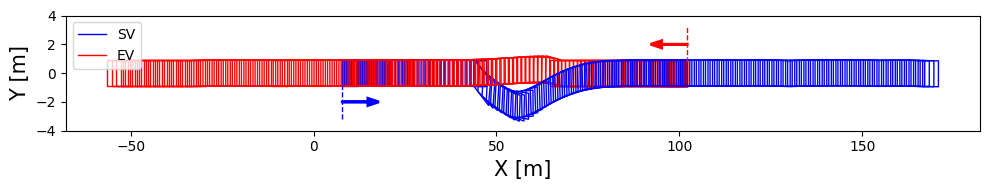

In [10]:
def rota_rect(state, l, w):
    # Note: the first four states must be x, y, heading, velocity
    x       = state[0]
    y       = state[1]
    box     = [(x - l/2, y + w/2), (x + l/2, y + w/2), (x + l/2, y - w/2), (x - l/2, y - w/2)]
    heading = state[2]
    
    box_matrix = np.array(box) - np.repeat(np.array([[x, y]]), len(box), 0)
    theta = -heading
    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    new = box_matrix.dot(rota_matrix) + np.repeat(np.array([[x, y]]), len(box), 0)
    
    x = [new[0][0], new[1][0], new[2][0], new[3][0], new[0][0]]
    y = [new[0][1], new[1][1], new[2][1], new[3][1], new[0][1]]
    return x, y


plt.figure(figsize=(10, 2), tight_layout=True)
for k in range(len(t)):
    x_SV, y_SV = rota_rect(State_SV[:, k], l_veh_sv, w_veh_sv)
    x_EV, y_EV = rota_rect(State_EV[:, k], l_veh_ev, w_veh_ev)

    plt.plot(x_SV, y_SV, c='b', linewidth=1, label='SV' if k == 0 else "")
    plt.plot(x_EV, y_EV, c='r', linewidth=1, label='EV' if k == 0 else "")

# Blue dashed line and arrow
plt.axvline(x = 10 - l_veh_sv/2, ymin = 0.1, ymax = 0.4, color='blue', linestyle='--', linewidth = 1)  # Adjust ymin and ymax based on axis limits
plt.arrow(10 - l_veh_sv/2, -2, 10, 0, color='blue', head_width = 0.5, head_length = 3, linewidth = 2, length_includes_head = True)

# Red dashed line and arrow
plt.axvline(x = 100 + l_veh_sv/2, ymin = 0.6, ymax  = 0.9, color = 'red', linestyle = '--', linewidth = 1)  # Adjust ymin and ymax based on axis limits
plt.arrow(100 + l_veh_sv/2, 2, -10, 0, color = 'red', head_width = 0.5, head_length = 3, linewidth = 2, length_includes_head = True)

plt.ylim(-4, 4)
plt.xlabel("X [m]", fontsize=15)
plt.ylabel("Y [m]", fontsize=15)
plt.legend()